In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

from sklearn import metrics
from sklearn.metrics import r2_score
from methods import *

In [2]:
initial_learning_rate = 0.01


In [3]:
x, y_lon, y_lat=fetch_data("x","y",2333,1,2)

In [5]:
x_scaler, x_scaled = Scaling(x)
lon_scaler, lon_scaled=Scaling(y_lon)
lat_scaler, lat_scaled=Scaling(y_lat)
y_scaled=np.append(lon_scaled,lat_scaled,axis = 1)




In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3) #, random_state=

In [7]:
#build model
def create_nn(
    learning_rate,
    num_dense_layers,
    neurons2,
    activation,
    neurons,
    drop_out1,
    drop_out2,
    _factor,
    _patience
    ):

    model = Sequential()
    model.add(Dense(neurons,input_dim=2333, activation=activation))
    model.add(Dropout(drop_out1))

    for i in range(num_dense_layers):
        model.add(Dense(neurons2,activation=activation,
                    ))
        model.add(Dropout(drop_out2))
    model.add(Dense(2))


    opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse', metrics=["mean_squared_error"])


    return model

In [8]:
#Hyperparameter Space
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=0, high=5, name='num_dense_layers')

neurons2 = Integer(low=4, high=2048, name='neurons2')
batch_size=Integer(low=32, high=256, name='batch_size')
neurons=Integer(low=4, high=2048, name='neurons')
drop_out1=Real(low=0.00001, high=0.4, prior='uniform', name='drop_out1',)
drop_out2=Real(low=0.00001, high=0.4, prior='uniform', name='drop_out2',)
_factor=Real(low=0.00001, high=0.99999, prior='uniform', name='_factor',)
_patience=Integer(low=1, high=10, name='_patience')
dim_activation = Categorical(
    categories=['relu','sigmoid'], name='activation',
)


In [9]:
param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              neurons2,
              dim_activation,
              batch_size,
              neurons,
              drop_out1,
              drop_out2,
             _factor,
              _patience
              ]

In [10]:
#number of epochs
epochs = 4
#save path
path_best_model = 'SkoptGP.h8_100'
#trying to mimimze loss function, therefore starting at infinity and any number would be less and would be counted as best loss
best_loss = 1000000000000000000000000000000000000000000000000000

In [11]:
#use names is a skopt funciton for referring to param hyperspace
@use_named_args(param_grid)
def objective(
        learning_rate,
        num_dense_layers,
        neurons2,
        activation,
        batch_size,
        neurons,
        drop_out1,
        drop_out2,
        _factor,
        _patience,


):
#printing paramater choice
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('neurons2:', neurons2)
    print('activation:', activation)
    print('batch_size', batch_size)
    print('neurons', neurons)
    print('drop_out1', drop_out1)
    print('drop_out2', drop_out2)
    print('_factor', _factor)
    print('_patience', _patience)
    print()

    model = create_nn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       neurons2=neurons2,
                       activation=activation,
                       neurons=neurons,
                       drop_out1=drop_out1,
                       drop_out2=drop_out2,
                       _factor=_factor,
                       _patience=_patience)
#learning rate reduction is used as call back and can be optimize as well
    learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                                patience=_patience,
                                                verbose=1,
                                                factor=_factor,
                                                min_lr=0.00001)


    history = model.fit(x=x_train,
                        y=y_train,
                        epochs=epochs,
                        #validation_split=0.1,
                        batch_size=batch_size,
                        callbacks=learning_rate_reduction)


    loss = history.history['loss'][-1]

    global best_loss
#if lost of last epoch is lower than best loss so far than keep the current model and save his loss as best so far
    if loss < best_loss:
        
        model.save(path_best_model)

        best_loss = loss

    del model

    return loss

In [12]:
fm_ = forest_minimize(
    objective,
    param_grid,
    acq_func='EI',
    n_calls=12,)
#    random_state=0,)

learning rate: 2.6e-06
num_dense_layers: 2
neurons2: 1844
activation: relu
batch_size 80
neurons 781
drop_out1 0.16160464370381547
drop_out2 0.17061384935899732
_factor 0.47569684375190835
_patience 9

Epoch 1/4
56/56 [==============================] - 3s 42ms/step - loss: 0.1873 - mean_squared_error: 0.1873 - lr: 2.5607e-06
Epoch 2/4
56/56 [==============================] - 2s 41ms/step - loss: 0.0906 - mean_squared_error: 0.0906 - lr: 2.5607e-06
Epoch 3/4
56/56 [==============================] - 2s 40ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - lr: 2.5607e-06
Epoch 4/4
56/56 [==============================] - 2s 41ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - lr: 2.5607e-06
INFO:tensorflow:Assets written to: SkoptGP.h8_100\assets
learning rate: 1.7e-03
num_dense_layers: 5
neurons2: 709
activation: relu
batch_size 163
neurons 1355
drop_out1 0.25062865995208594
drop_out2 0.36875289130571
_factor 0.05078085260453222
_patience 3

Epoch 1/4
28/28 [========================

26/26 [==============================] - 0s 4ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - lr: 0.0046
Epoch 2/4
26/26 [==============================] - 0s 3ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - lr: 0.0046
Epoch 3/4
26/26 [==============================] - 0s 3ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - lr: 0.0046
Epoch 4/4
26/26 [==============================] - 0s 3ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - lr: 0.0046


In [13]:
"Best score=%.4f" % fm_.fun

'Best score=0.0119'

In [14]:
for position, name in enumerate(fm_.space.dimension_names):
    print(f"{name}   {fm_.x[position]}")

learning_rate   0.00021216256061843002
num_dense_layers   1
neurons2   1354
activation   relu
batch_size   69
neurons   1486
drop_out1   0.22295468428344808
drop_out2   0.03222932536574698
_factor   0.7932319171177068
_patience   10


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

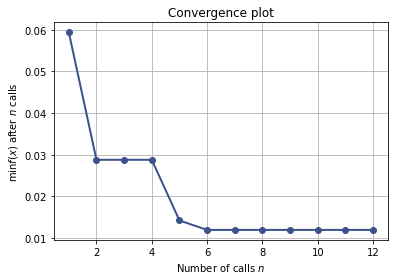

In [15]:
plot_convergence(fm_)

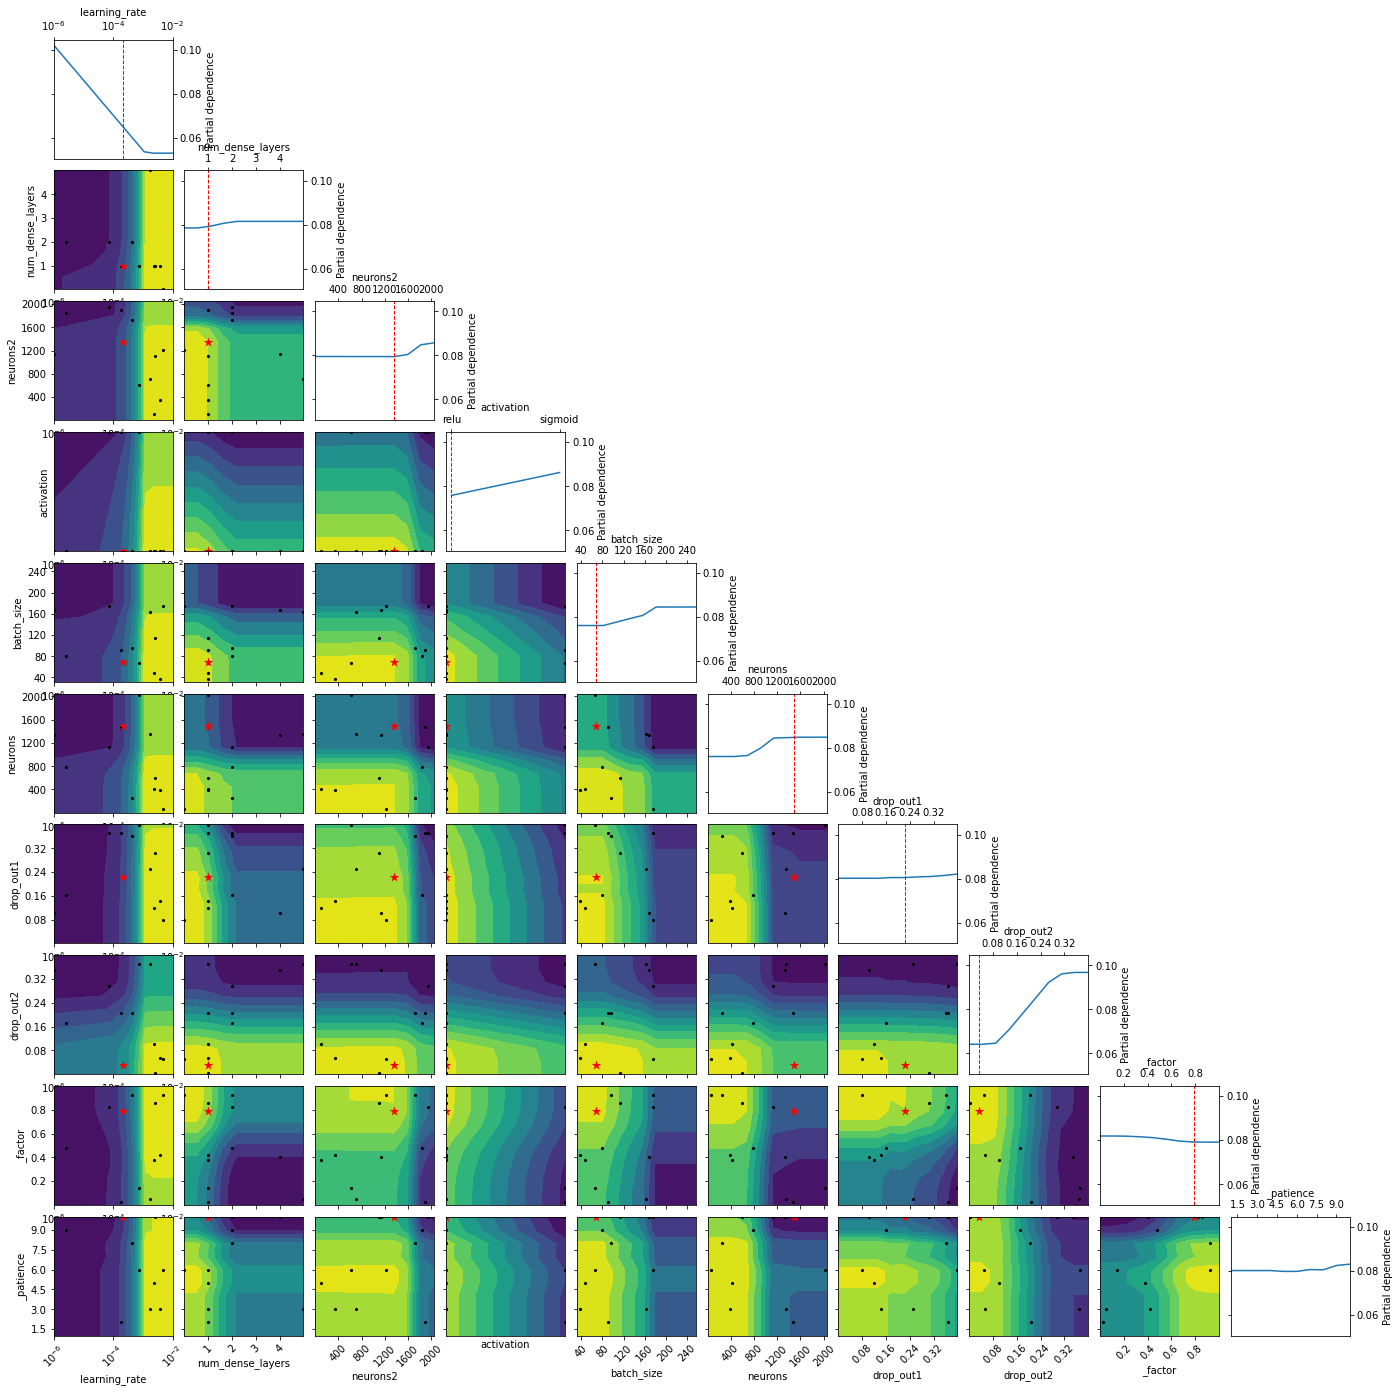

In [16]:
plot_objective(result=fm_,n_points=10)
plt.show()

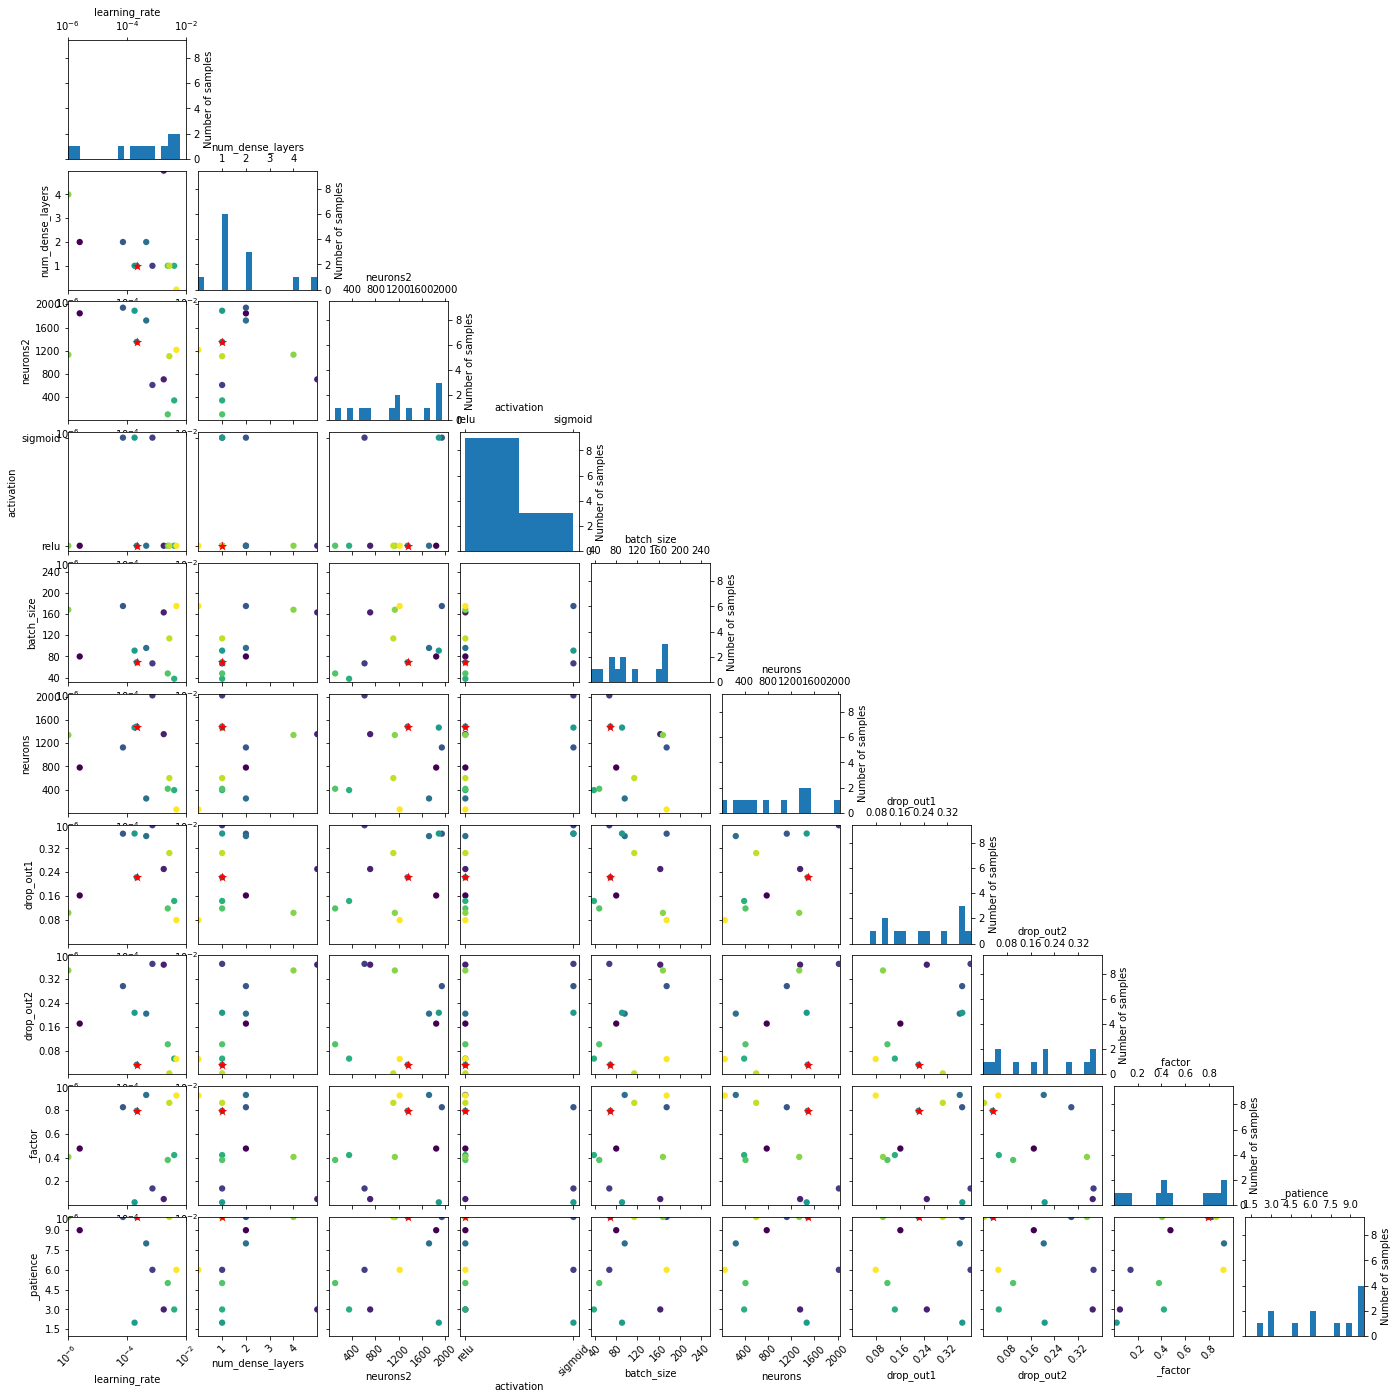

In [17]:
plot_evaluations(result=fm_)
plt.show()

In [24]:
model = load_model(path_best_model)
predictions = model.predict(x_test)


60/60 [==============================] - 0s 6ms/step


In [26]:
#modeling final results
pred_lon=inv_scaler(lon_scaler, predictions[:,0])
pred_lat=inv_scaler(lat_scaler, predictions[:,1])

lat_test=inv_scaler(lat_scaler,y_test[:,1].reshape(-1,1))
lon_test=inv_scaler(lon_scaler,y_test[:,0].reshape(-1,1))


Text(0.5, 1.0, 'Combined')

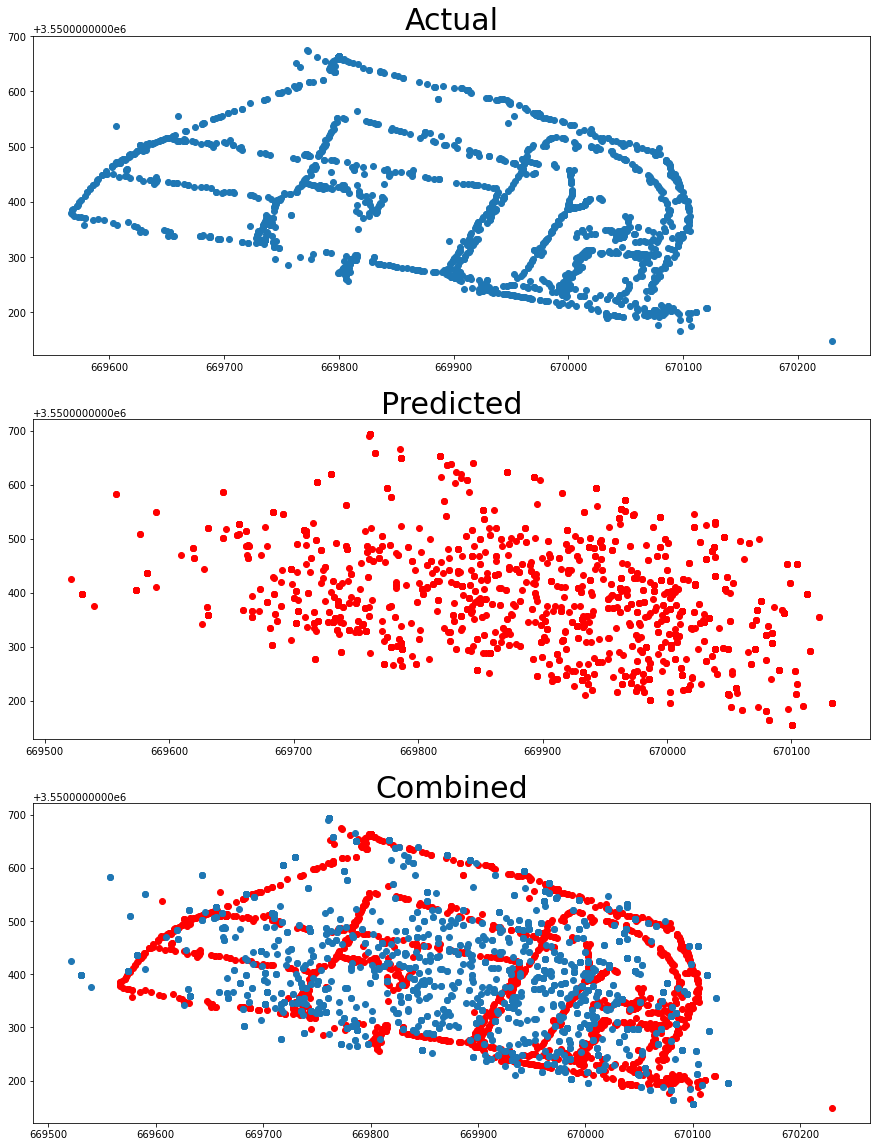

In [27]:
fig, ax = plt.subplots(3)

ax[0].scatter(lon_test,lat_test)
fig.set_size_inches(15,20)
ax[0].set_title("Actual", size= 30)
ax[1].scatter(pred_lon,pred_lat, color="red")
ax[1].set_title("Predicted", size= 30)
ax[2].scatter(lon_test,lat_test, color="red")
ax[2].scatter(pred_lon,pred_lat)
ax[2].set_title("Combined", size= 30)


In [28]:
results, difs_df_sorted=calculate_diff(lon_test,pred_lon,lat_test,pred_lat)

In [29]:
results

,lon_test,pred_lon,lat_test,pred_lat,diff
0,344.717,306.8530,176.526,175.058,37.892447
1,431.187,418.9780,94.448,93.058,12.287871
2,420.844,441.4155,204.479,159.808,49.180127
3,438.406,464.7905,391.367,376.808,30.134802
4,447.506,436.1030,154.465,155.558,11.455263
...,...,...,...,...,...
1904,247.769,312.2905,145.837,295.308,162.802346
1905,272.321,380.7280,137.926,294.058,190.077035
1906,47.106,53.4780,328.026,317.058,12.684613
1907,82.702,148.6655,367.002,380.308,67.292146


In [30]:
print(difs_df_sorted.quantile(q=0.8))
print(difs_df_sorted.quantile(q=0.85))
print(difs_df_sorted.quantile(q=0.9))
print(difs_df_sorted.median())


diff    118.828502
Name: 0.8, dtype: float64
diff    148.336794
Name: 0.85, dtype: float64
diff    183.895541
Name: 0.9, dtype: float64
diff    49.179419
dtype: float64
